In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('../data/data.csv')
print(df.head())

         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    ChannelId   Amount  Value  TransactionStart

In [7]:
#  Calculate RFMS Scores
# Convert transaction_date to datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Calculate RFMS Scores
current_date = df['TransactionStartTime'].max()  # Most recent transaction date
rfms_df = df.groupby('CustomerId').agg(
    Recency=('TransactionStartTime', lambda x: (current_date - x.max()).days),
    Frequency=('TransactionId', 'count'),
    Monetary=('Amount', 'sum')
).reset_index()


In [6]:
# Display the column names
print(df.columns.tolist())

['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'TtransactionStartTime']


In [8]:

# For simplicity, let's assume all customers have a satisfaction score of 1
rfms_df['Satisfaction'] = 1  # Placeholder score

# Calculate RFMS Score (you can adjust weights as needed)
rfms_df['RFMS_Score'] = (rfms_df['Recency'] * 0.25 +
                          rfms_df['Frequency'] * 0.25 +
                          rfms_df['Monetary'] * 0.25 +
                          rfms_df['Satisfaction'] * 0.25)  # Adjust weights as needed


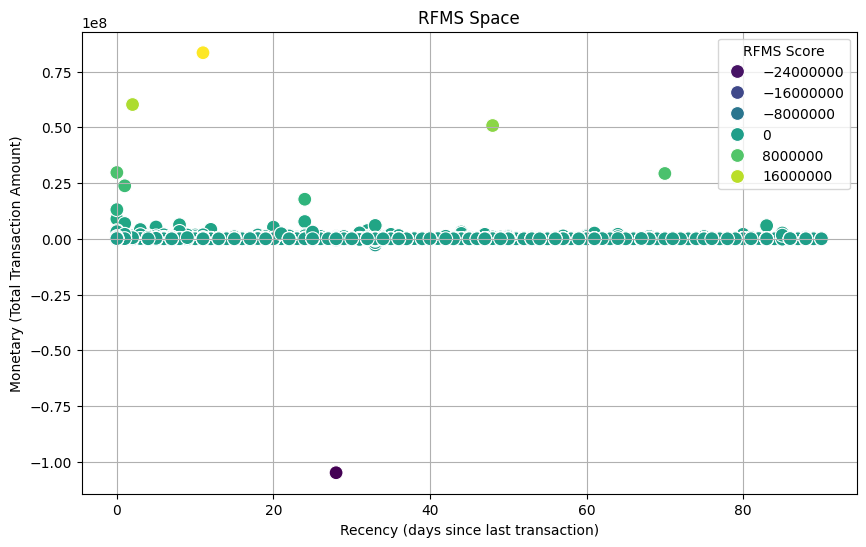

In [9]:
# Step 4: Visualize RFMS Space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfms_df, x='Recency', y='Monetary', hue='RFMS_Score', palette='viridis', s=100)
plt.title('RFMS Space')
plt.xlabel('Recency (days since last transaction)')
plt.ylabel('Monetary (Total Transaction Amount)')
plt.legend(title='RFMS Score')
plt.grid()
plt.show()

In [10]:

#  Establish a Boundary
threshold = rfms_df['RFMS_Score'].median()  # Using median as a threshold

#  Assign Labels
rfms_df['Risk_Label'] = np.where(rfms_df['RFMS_Score'] >= threshold, 'Good', 'Bad')

# Display the DataFrame with RFMS scores and labels
print(rfms_df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'RFMS_Score', 'Risk_Label']].head())

        CustomerId  Recency  Frequency  Monetary  RFMS_Score Risk_Label
0     CustomerId_1       83          1  -10000.0    -2478.75        Bad
1    CustomerId_10       83          1  -10000.0    -2478.75        Bad
2  CustomerId_1001       89          5   20000.0     5023.75       Good
3  CustomerId_1002       25         11    4225.0     1065.50        Bad
4  CustomerId_1003       11          6   20000.0     5004.50        Bad


###Explanation of the Code
Loading Data: The dataset is loaded from an Excel file. Make sure to specify the correct file path.
Preprocessing:
The TransactionStartTime column is converted to a datetime format for proper date calculations.
Calculating RFMS Scores:
Recency: The number of days since the last transaction for each customer.
Frequency: The total number of transactions per customer.
Monetary: The total amount spent by each customer.
A placeholder Satisfaction score is set to 1 for simplicity. You can adjust this based on your data.
Visualizing RFMS Space: A scatter plot is created to visualize the RFMS scores.
Establishing a Boundary: The median RFMS score is used to classify customers into "Good" or "Bad".
Assigning Labels: Each customer is labeled based on their RFMS score.

### Perform Weight of Evidence

In [11]:

#  Define a function to calculate WoE
def calculate_woe(df, target, variable, bins):
    # Create bins
    df['binned'] = pd.cut(df[variable], bins=bins, include_lowest=True)
    
    # Calculate the number of good and bad for each bin
    grouped = df.groupby('binned')[target].agg(['count', 'sum']).reset_index()
    grouped.columns = ['binned', 'total', 'bad']
    
    # Calculate good and bad counts
    grouped['good'] = grouped['total'] - grouped['bad']
    
    # Calculate WoE
    total_good = df[target].value_counts()[0]  # Assuming 0 is 'Good'
    total_bad = df[target].value_counts()[1]   # Assuming 1 is 'Bad'
    
    grouped['woe'] = np.log((grouped['good'] / total_good) / (grouped['bad'] / total_bad))
    
    return grouped[['binned', 'woe']]

In [13]:

# Calculate Recency, Frequency, Monetary
current_date = df['TransactionStartTime'].max()  # Most recent transaction date
rfms_df = df.groupby('CustomerId').agg(
    Recency=('TransactionStartTime', lambda x: (current_date - x.max()).days),
    Frequency=('TransactionId', 'count'),
    Monetary=('Amount', 'sum')
).reset_index()

#  Create a Default Label
# This is just a placeholder; you should replace it with your actual default logic
# For this example, let's assume 30% of users defaulted randomly
np.random.seed(42)  # For reproducibility
rfms_df['Default'] = np.random.choice([0, 1], size=len(rfms_df), p=[0.7, 0.3])

In [14]:
#   WoE Calculation Function
def calculate_woe(df, target, variable, bins):
    df['binned'] = pd.cut(df[variable], bins=bins, include_lowest=True)
    
    # Calculate the number of good and bad for each bin
    grouped = df.groupby('binned')[target].agg(['count', 'sum']).reset_index()
    grouped.columns = ['binned', 'total', 'bad']
    
    grouped['good'] = grouped['total'] - grouped['bad']
    
    total_good = df[target].value_counts().get(0, 0)  # Assuming 0 is 'Good'
    total_bad = df[target].value_counts().get(1, 0)   # Assuming 1 is 'Bad'
    
    # Calculate WoE
    grouped['woe'] = np.log((grouped['good'] / total_good) / (grouped['bad'] / total_bad))
    
    return grouped[['binned', 'woe']]

In [15]:

#  Define bins for Recency
recency_bins = [0, 30, 60, 90, 120, 180, 365]  # Example bins

#  Calculate WoE for Recency
woe_recency = calculate_woe(rfms_df, 'Default', 'Recency', recency_bins)

#   Merge WoE back into the original DataFrame
rfms_df = rfms_df.merge(woe_recency, on='binned', how='left')

#  Replace the original variable with WoE values
rfms_df['Recency_WoE'] = rfms_df['woe']

#  Calculate RFMS Score
rfms_df['RFMS_Score'] = (rfms_df['Recency'] * 0.25 +
                          rfms_df['Frequency'] * 0.25 +
                          rfms_df['Monetary'] * 0.25)  # Adjust weights as necessary

#   Assign Risk Labels
threshold = rfms_df['RFMS_Score'].median()  # Using median as a threshold
rfms_df['Risk_Label'] = np.where(rfms_df['RFMS_Score'] >= threshold, 'Good', 'Bad')

# Display the final DataFrame with relevant columns
print(rfms_df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'RFMS_Score', 'Risk_Label', 'Recency_WoE']].head())

        CustomerId  Recency  Frequency  Monetary  RFMS_Score Risk_Label  \
0     CustomerId_1       83          1  -10000.0    -2479.00        Bad   
1    CustomerId_10       83          1  -10000.0    -2479.00        Bad   
2  CustomerId_1001       89          5   20000.0     5023.50       Good   
3  CustomerId_1002       25         11    4225.0     1065.25        Bad   
4  CustomerId_1003       11          6   20000.0     5004.25        Bad   

   Recency_WoE  
0    -0.063762  
1    -0.063762  
2    -0.063762  
3     0.030161  
4     0.030161  


C:\Users\Tesfaye\AppData\Local\Temp\ipykernel_8148\971133610.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('binned')[target].agg(['count', 'sum']).reset_index()


###Explanation of the Code
Loading Data: The dataset is loaded from an Excel file, and the TransactionStartTime is converted to datetime.
Calculating RFMS Scores:
Recency: Days since the last transaction.
Frequency: Total number of transactions.
Monetary: Total amount spent.
Creating a Default Label: A random assignment of defaults is made for demonstration. Replace this logic with your actual default determination.
Calculating WoE:
A function calculates the WoE for the binned Recency values.
The bins are created using pd.cut(), and the WoE is calculated based on the counts of good and bad in each bin.
Merging and Updating: The original DataFrame is updated with the WoE values for Recency.
Calculating RFMS Score: The RFMS score is calculated based on Recency, Frequency, and Monetary values.
Assigning Risk Labels: Customers are labeled as "Good" or "Bad" based on their RFMS score relative to the median score.